In [1]:
# Import modules
import os
import numpy as np
import pandas as pd
import xnat
import pydicom
import matplotlib.pyplot as plt

# XNAT module trial
- A new XNAT client that exposes XNAT objects/functions as python
objects/functions. The aim is to abstract as much of the REST API
away as possible and make xnatpy feel like native Python code. This
reduces the need for the user to know the details of the REST API.
Low level functionality can still be accessed via the connection object
which has get, head, put, post, delete methods for more
directly calling the REST API.
- [XNAT Python Client Usage Documentation](https://xnat.readthedocs.io/en/latest/)
- [XNATpy Github](https://gitlab.com/radiology/infrastructure/xnatpy)
- [JHU Tutorials: How to Access DICOMs from XNAT via Jupyter Tutorial](https://pm.jh.edu/cookbook/Demo_Access_DICOMs.html)

In [2]:
# Connect to your XNAT Session URL and XNAT User ID
session = xnat.connect('http://localhost', user = 'admin')

Please enter the password for user 'admin': ········


## View All Accessible Studies in XNAT
You can browse the following levels on the XNAT server: 
- projects
- subjects
- experiments
- scans
- resources
- files

Also under experiments you have assessors which again can contain resources and files.
This all following the same structure as XNAT.ts

### Projects

In [4]:
# View all accessible projects in XNAT
session.projects

<XNATListing {(20231206, Sample RSNA-MICCAI Brain Tumor Radiogenomic Classification): <ProjectData Sample RSNA-MICCAI Brain Tumor Radiogenomic Classification (20231206)>, (20231211, Nodules in Chest X-rays (LIDC-IDRI)): <ProjectData Nodules in Chest X-rays (LIDC-IDRI) (20231211)>}>

In [15]:
for key, value in session.projects.items():
    print('key: ', key, end='\n')
    print('value: ', value, end='\n\n')

key:  20231206
value:  <ProjectData Sample RSNA-MICCAI Brain Tumor Radiogenomic Classification (20231206)>

key:  20231211
value:  <ProjectData Nodules in Chest X-rays (LIDC-IDRI) (20231211)>



In [16]:
rsna_project = session.projects["20231206"]
lidc_project = session.projects["20231211"]

#### (+) Low level REST directives

In [28]:
session.get('/data/projects')
# Note that 'https://xnat.example.com/data/projects' would also work but is not needed
# as the connection already knows the server connected to

<Response [200]>

In [30]:
session.get_json('/data/projects/20231211')

{'items': [{'children': [],
   'meta': {'create_event_id': 51,
    'xsi:type': 'xnat:projectData',
    'isHistory': False,
    'start_date': 'Mon Dec 11 09:13:42 UTC 2023'},
   'data_fields': {'secondary_ID': 'LIDC-IDRI',
    'name': 'Nodules in Chest X-rays (LIDC-IDRI)',
    'active': 'true',
    'ID': '20231211'}}]}

### Subjects

In [24]:
print('rsna_project :', len(rsna_project.subjects), ' subjects')
print('lidc_project :', len(lidc_project.subjects), ' subjects')

rsna_project : 26  subjects
lidc_project : 268  subjects


### Experiment

In [141]:
# XNAT_S00001 ; (Accession #)
rsna_project.subjects['XNAT_S00001'].experiments['XNAT_E00004']

<MrSessionData 00337 (XNAT_E00004)>

#### (+) Selecting an object based on its uri
- If you already have the uri for an object you can easily fetch the correct xnatpy object.
- `experiment_object = connection.create_object('/data/projects/$PROJECT_ID/experiments/$EXPERIMENT_ID')`

In [47]:
session.create_object('/data/projects/20231206/experiments/00047') # <MrSessionData EXPERIMENT_LABEL (EXPERIMENT_ID)

<MrSessionData 00047 (XNAT_E00019)>

## Searching
- XNATpy allows using the XNAT search via the REST API. For this XNAT expects an XML document that specifies your query.
- The general information on search with the XNAT REST API is taken from XNAT wiki: [How to Query the XNAT Search Engine with REST API](https://wiki.xnat.org/display/XAPI/How+to+Query+the+XNAT+Search+Engine+with+REST+API)
- == : equals
- <= : smaller or equal
- < : smaller
- like : like for fuzzy string matching
- & : AND operator / e.g. (a==b)&(c==d)
- | : OR operator

In [ ]:
# [example] Subject data class
SubjectData = session.classes.SubjectData
SubjectData.query().filter(SubjectData.project == '20231206').all()

In [ ]:
# Multiple constraints can be used by giving multiple arguments to filter:
SubjectData.query().filter(SubjectData.project == '20231206',
                          SubjectData.label.like('000*')).all()

In [ ]:
# Also, filter can be called on the resulting query to stack filters:
SubjectData.query().filter(SubjectData.project == '20231206').filter(SubjectData.label.like('000*')).all()

In [ ]:
# Finally compound constraints can be created using the & (for and) and | (for or) operators:
SubjectData.query().filter( (SubjectData.project == '20231206') & (SubjectData.label.like('000*')) ).all()

- Other option than `.all()` method

In [67]:
query = SubjectData.query().filter( (SubjectData.project == '20231206') & (SubjectData.label.like('0001*')) )

In [68]:
query.all()

[<SubjectData 00001 (XNAT_S00002)>,
 <SubjectData 00015 (XNAT_S00007)>,
 <SubjectData 00013 (XNAT_S00011)>]

In [69]:
query.first()

<SubjectData 00001 (XNAT_S00002)>

In [70]:
query.last()

<SubjectData 00013 (XNAT_S00011)>

In [71]:
query.tabulate_csv()

'subject_label,subjectid,insert_user,insert_date,projects,project,gender,handedness,dob,educ,ses,quarantine_status\n00001,XNAT_S00002,admin,2023-12-06 10:26:40.53,",<20231206>",20231206,,,,,,active\n00015,XNAT_S00007,admin,2023-12-06 10:26:57.977,",<20231206>",20231206,,,,,,active\n00013,XNAT_S00011,admin,2023-12-06 10:27:05.306,",<20231206>",20231206,,,,,,active\n'

In [72]:
query.tabulate_dict()

[{'subject_label': '00001',
  'subjectid': 'XNAT_S00002',
  'insert_user': 'admin',
  'insert_date': '2023-12-06 10:26:40.53',
  'projects': ',<20231206>',
  'project': '20231206',
  'gender': '',
  'handedness': '',
  'dob': '',
  'educ': '',
  'ses': '',
  'quarantine_status': 'active'},
 {'subject_label': '00015',
  'subjectid': 'XNAT_S00007',
  'insert_user': 'admin',
  'insert_date': '2023-12-06 10:26:57.977',
  'projects': ',<20231206>',
  'project': '20231206',
  'gender': '',
  'handedness': '',
  'dob': '',
  'educ': '',
  'ses': '',
  'quarantine_status': 'active'},
 {'subject_label': '00013',
  'subjectid': 'XNAT_S00011',
  'insert_user': 'admin',
  'insert_date': '2023-12-06 10:27:05.306',
  'projects': ',<20231206>',
  'project': '20231206',
  'gender': '',
  'handedness': '',
  'dob': '',
  'educ': '',
  'ses': '',
  'quarantine_status': 'active'}]

In [73]:
# This requires pandas to be installed
query.tabulate_pandas()

,subject_label,subjectid,insert_user,insert_date,projects,project,gender,handedness,dob,educ,ses,quarantine_status
0,1,XNAT_S00002,admin,2023-12-06 10:26:40.53,",<20231206>",20231206,NaN,NaN,NaN,NaN,NaN,active
1,15,XNAT_S00007,admin,2023-12-06 10:26:57.977,",<20231206>",20231206,NaN,NaN,NaN,NaN,NaN,active
2,13,XNAT_S00011,admin,2023-12-06 10:27:05.306,",<20231206>",20231206,NaN,NaN,NaN,NaN,NaN,active


## Accessing XNAT files as local files (partial read)
There is a helper that allows you to open a remote file (FileData object) similarly as a local file. Note that it will read the file from the start and until it is done, seeking will download until the seek point.
- The file is read in `chucks` so there might be a bit too much data downloaded
- If you open the file and not `close` it, the memory buffer might not be cleaned properly
- (you don't need to explicitly close the file, because the `with` statement handles the file closing for you when it's done executing the code inside the block)

In [83]:
file_obj = session.projects['20231211'].subjects['XNAT_S00027'].experiments['XNAT_E00030'].scans['30088'].resources['DICOM'].files[0]

In [89]:
num = 100

with file_obj.open() as fin: #fin; file name
    data = fin.read(num)
print(len(data))

100


You can also use this to read the headers of a dicom file using `pydicom`:
- [Pydicom 모듈 사용 예시 참고](https://89douner.tistory.com/284)
- [Pydicom github](https://github.com/pydicom/pydicom)
- [Pydicom documentation; general examples](https://pydicom.github.io/pydicom/stable/auto_examples/index.html)
- [Pydicom dataset basics: read, access, modify, write](https://pydicom.github.io/pydicom/stable/tutorials/dataset_basics.html)
- [Pydicom core elements](https://pydicom.github.io/pydicom/stable/old/base_element.html)

In [91]:
# Only headers
with file_obj.open() as fin:
    header = pydicom.dcmread(fin, stop_before_pixels=True)

In [92]:
header

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 194
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Computed Radiography Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.14519.5.2.1.6279.6001.116841327318857371262151268299
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'dcm4che-1.4.35'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['DERIVED', 'PRIMARY']
(0008, 0016) SOP Class UID                       UI: Computed Radiography Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.14519.5.2.1.6279.6001.116841327318857371262151268299
(000

In [148]:
with file_obj.open() as fin:
    dcm = pydicom.dcmread(fin)
    sex = dcm.PatientSex
    snum = dcm.SeriesNumber
    img = dcm.pixel_array

In [154]:
print(f'series number: {snum} \nsex: {sex} \nimage type: {type(img)} \nimage shape: {img.shape}')  # shape -  (channel; 시간 축), width, height

series number: 30088 
sex: M 
image type: <class 'numpy.ndarray'> 
image shape: (2897, 2749)


In [164]:
# If you don’t remember or know the exact element tag or keyword,
print(dcm.dir("pat"))
print(dcm.dir("uid"))

['PatientBirthDate', 'PatientID', 'PatientIdentityRemoved', 'PatientName', 'PatientSex']
['FrameOfReferenceUID', 'SOPClassUID', 'SOPInstanceUID', 'SeriesInstanceUID', 'StudyInstanceUID']


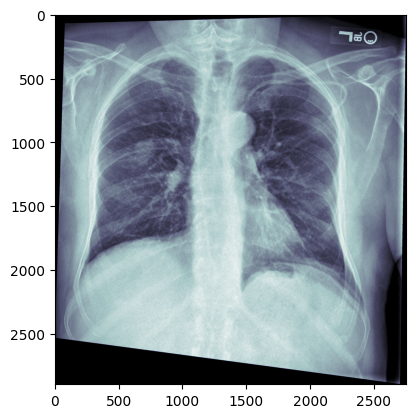

In [98]:
# Image 
plt.imshow(img, cmap=plt.cm.bone)

## Example scripts

In [ ]:
#!/usr/bin/env python

import xnat
import argparse
import re


def get_files(connection, project, subject, session, scan):
    xnat_project = connection.projects[project]
    xnat_subject = xnat_project.subjects[subject]
    xnat_experiment = xnat_subject.experiments[session]
    xnat_scan = xnat_experiment.scans[scan]
    files = xnat_scan.files.values()
    return files


def filter_files(xnat_files, regex):
    filtered_files = []
    regex = re.compile(regex)
    for file in xnat_files:
        found = regex.match(file.name)
        if found:
            filtered_files.append(file)
    return filtered_files


def main():
    parser = argparse.ArgumentParser(description='Prints all files from a certain scan.')
    parser.add_argument('--xnathost', type=unicode, required=True, help='xnat host name')
    parser.add_argument('--project', type=unicode, required=True, help='Project id')
    parser.add_argument('--subject', type=unicode, required=True, help='subject')
    parser.add_argument('--session', type=unicode, required=True, help='session')
    parser.add_argument('--scan', type=unicode, required=True, help='scan')
    parser.add_argument('--filter', type=unicode, required=False, default='.*', help='regex filter for file names')
    args = parser.parse_args()

    with xnat.connect(args.xnathost) as connection:
        xnat_files = get_files(connection, args.project, args.subject, args.session, args.scan)
        xnat_files = filter_files(xnat_files, args.filter)
        for file in xnat_files:
            print('{}'.format(file.name))


if __name__ == '__main__':
    main()